In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local'
sys.path.insert(0,path_to_mavenn_local)

import mavenn
import time
from mavenn.src.utils import onehot_encode_array
from mavenn.src.validate import alphabet_dict

In [2]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']

In [3]:
# load data
data_df = mavenn.load_example(which='test_data',name='gb1')
x = data_df['x'].values
y = data_df['y'].values

# oh-encode data
x_ohe = onehot_encode_array(x,
                            bases_dict=alphabet_dict['protein'].tolist(),
                            ohe_single_batch_size=len(data_df)-1)

## Sklearn implementation

In [4]:
# import numpy as np
# from sklearn.linear_model import LinearRegression

# start_time = time.time()
# reg = LinearRegression().fit(x_ohe, y)
# fit_time = time.time()-start_time
# f'{fit_time:.4f} seconds'

In [5]:
# # Non-gauge fixed theta
# theta_all = reg.coef_
# theta_nought = reg.intercept_
# theta_unfixed = np.hstack((theta_nought, theta_all.ravel()))

In [6]:
# theta_unfixed.shape

In [7]:
# sns.heatmap(theta_all.reshape(9,4),cmap='PiYG')

## TF SGD implementation

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import Adam

In [9]:
inputTensor = Input((len(x_ohe[0]),))
outputTensor = Dense(1)(inputTensor)
model = Model(inputTensor,outputTensor)
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.001))

In [10]:
start_time = time.time()
history = model.fit(x_ohe, y, validation_split=0.0, epochs=10,verbose=0)
fit_time = time.time()-start_time
f'fit time: {fit_time:.4f} seconds'

'fit time: 18.8869 seconds'

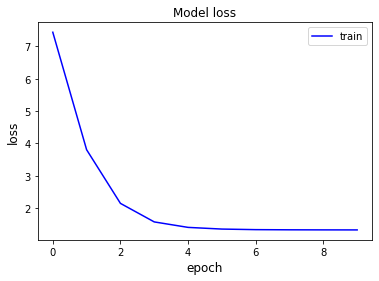

In [11]:
plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [12]:
# Non-gauge fixed theta
theta_all = model.layers[1].get_weights()[0].ravel()
theta_nought = model.layers[1].get_weights()[1].ravel()
theta_unfixed = np.hstack((theta_nought, theta_all.ravel()))

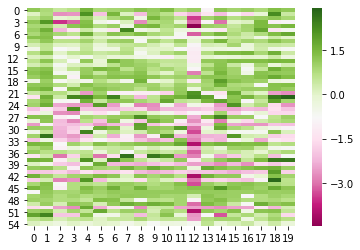

In [13]:
sns.heatmap(theta_all.reshape(55,20),cmap='PiYG')

In [14]:
# Rsq = np.corrcoef(reg.predict(x_ohe),model.predict(x_ohe).ravel())[0][1]**2
# plt.scatter(reg.predict(x_ohe),model.predict(x_ohe),s=1,alpha=0.2)
# plt.xlabel('sklearn predictions')
# plt.ylabel('SGD predictions')
# plt.title('$R^2$: '+str(Rsq)[0:5])
# plt.show()

## Sparse Implementation

In [15]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html
# Solve y = X*theta

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

In [16]:
# add bias term in design matrix
# x_ohe_with_bias = np.hstack([np.ones((x_ohe.shape[0],1)),x_ohe])

# start_time = time.time()
# x_sparse = csc_matrix(x_ohe_with_bias)
# sparse_time = time.time()-start_time
# f'Sparsing time: {sparse_time:.4f} seconds'

In [17]:
start_time = time.time()
x_sparse = csc_matrix(x_ohe)
sparse_time = time.time()-start_time
f'Sparsing time: {sparse_time:.4f} seconds'

'Sparsing time: 1.7219 seconds'

In [18]:
start_time = time.time()
theta, istop, itn, r1norm = lsqr(x_sparse, y)[:4]
training_time = time.time()-start_time
f'fit time {training_time:.4f} seconds'

'fit time 0.5232 seconds'

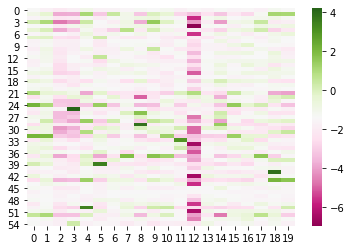

In [19]:
sns.heatmap(theta.reshape(55,20),cmap='PiYG')

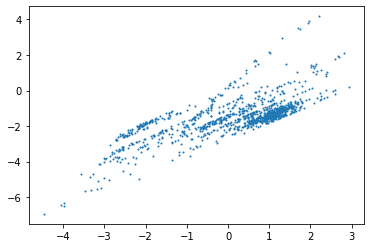

In [20]:
plt.scatter(theta_all,theta,s=1)
plt.show()